## sentiment analysis in pytorch

In [92]:
import os
import re
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import TweetTokenizer

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [93]:
data_path = Path(r"C:\Users\bamilosin\Documents\dataset\nlp\sentiment data")
train_path = data_path / "train.csv"
test_path = data_path / "test.csv"

In [21]:
# get data.csv encoding

from charset_normalizer import detect

with open(train_path, 'rb') as file:
    result = detect(file.read())
    print(result)

{'encoding': 'windows-1250', 'language': 'English', 'confidence': 0.9676666666666667}


In [109]:
train_data = pd.read_csv(train_path, encoding=result['encoding'])
train_data = train_data[['text', 'sentiment']] # the two columns we need.

# remove null values
train_data = train_data.dropna()
train_data = train_data.reset_index() # reset index because of removed rows
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      27480 non-null  int64 
 1   text       27480 non-null  object
 2   sentiment  27480 non-null  object
dtypes: int64(1), object(2)
memory usage: 644.2+ KB


## create dataset

In [124]:
class SentimentDataset(Dataset):
    def __init__(self, df, csv_encoding:str="windows-1250"):
        super(SentimentDataset, self).__init__()
        
        self.df = df
        self.df.loc[:, 'text'] = self.df.loc[:, 'text'].apply(self.clean_data) # clean data
        self.df.loc[:, 'tokens'] = self.df.loc[:, 'text'].apply(self.tokenize_data) # tokenize data

        self.all_tokens = list(self.df.loc[:, 'tokens'].values) # get all tokens
        self.longest_seq = self.get_longest_seq(self.all_tokens) # get longest token
        self.corpus = sorted(list(set([text for sublist in self.all_tokens for text in sublist]))) # set of words

        self.vocab = self.create_vocab(self.corpus) # create vocab
        self.idx2word = {idx : key for key, idx in self.vocab.items()} # idx to word

        self.df.loc[:, 'tokens'] = self.df.loc[:, 'tokens'].apply(lambda x : self.pad_token(x, self.longest_seq, self.idx2word[0])) # pad tokens

        self.df.loc[:, 'indices'] = self.df.loc[:, 'tokens'].apply(lambda x: self.create_indices(self.vocab, x)) # create indices

        self.label_map = {
            'negative' : 0,
            'positive': 1,
            'neutral' : 2
        }

        self.df.loc[:, 'labels'] = self.df.loc[:, 'sentiment'].apply(lambda x : self.labelizer(x, self.label_map)) # get label id
       

    def clean_data(self, text):
        text_lower = text.lower()
        clean_text = re.sub('[<>{};@#$%^&*()>]', '', text_lower)
        return clean_text
    
    def tokenize_data(self, text):

        stopwords = nltk.corpus.stopwords.words('english')
        tokenizer = nltk.TweetTokenizer()
        tokens = tokenizer.tokenize(text)

        # remove stopwords
        tokens = [token for token in tokens if token not in stopwords]
        return tokens
    
    def get_longest_seq(self, token_lists):
        longest_seq = 0
        for token_list in token_lists:
            if len(token_list) > longest_seq:
                longest_seq = len(token_list)

        return longest_seq

    def pad_token(self, token_list, longest_seq, pad_token:str='<PAD>'):
        if len(token_list) < longest_seq:
            return token_list + [pad_token for _ in range(longest_seq - len(token_list))]
        else:
            return token_list
        
    def create_vocab(self, corpus):
        vocab = {
            "<PAD>": 0
        }

        for word in corpus:
            vocab[word] = (len(vocab) - 1) +  1


        return vocab
    
    def create_indices(self, vocab, tokens):
        return [vocab[token] for token in tokens]
    
    def labelizer(self, label, label_map):
        return label_map[label]
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        indices, label = self.df[['indices', 'labels']].loc[idx].values
        indices = torch.tensor(indices, dtype=torch.int)
        label = torch.tensor(label)

        return indices, label    
    

In [125]:
dataset = SentimentDataset(train_data)
indices = torch.randperm(len(dataset)).tolist()

train_size = 0.7
train_dataset = Subset(dataset, indices[:int(train_size*len(dataset))])
test_dataset = Subset(dataset, indices[int(train_size*len(dataset)):])

BATCH_SIZE = 128
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

In [112]:
indices, labels = next(iter(train_dataloader))

In [113]:
VOCAB_SIZE = len(dataset.vocab)
EMBED_DIM = 128

## The Model: Transformer Encoder

In [114]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size:int, embedding_dim:int, nhead:int, mlp_size:int, num_layers:int):
        super(SentimentClassifier, self).__init__()
        
        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.pos_embedding = torch.randn(1, 1, embedding_dim, requires_grad=True, device=device)
        self.encoder = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                  nhead=nhead,
                                                  dim_feedforward=mlp_size,
                                                  batch_first=True)
        self.encoder_block = nn.TransformerEncoder(encoder_layer=self.encoder, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=16),
            nn.Tanh(),
            nn.Linear(in_features=16, out_features=3)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.embedding_layer(x)
        # get positional embeddings for each batch
        pos_embed = self.pos_embedding.expand(batch_size,  1, x.shape[-1])
        # add token embeddings to positional embeddings
        pos_token_embeddings = pos_embed + x
        x = self.encoder_block(pos_token_embeddings)
        return self.classifier(x[:, -1])

In [79]:
model = SentimentClassifier(vocab_size=VOCAB_SIZE,
                            embedding_dim=EMBED_DIM,
                            nhead=8,
                            mlp_size=512,
                            num_layers=4).to(device)
model

SentimentClassifier(
  (embedding_layer): Embedding(27181, 128)
  (encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder_block): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout):

In [115]:
def accuracy(y_logits, y_true):
    acc = torch.eq(torch.argmax(y_logits, dim=-1), y_true).sum().item()
    return (acc / len(y_true)) * 100.0

LR = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss().to(device)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1000, 0.1)

In [116]:
def train(model, dataloader, epochs, optimizer, loss_fn, scheduler):

    history = {
        "train_loss": [],
        "train_acc": []
    }

    model.train()
    for epoch in range(epochs):
        train_loss, train_acc = 0.0, 0.0
        for indices, labels in dataloader:
            indices, labels = indices.to(device), labels.to(device)

            logits = model(indices)
            loss = loss_fn(logits, labels)
            acc = accuracy(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            scheduler.step()

            train_loss += loss.item()
            train_acc += acc

        train_loss /= len(dataloader)
        train_acc /= len(dataloader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        print(f"{epoch+1}/{epochs} | train_loss: {train_loss:.5f} | train_acc: {train_acc:.2f}% | lr: {optimizer.param_groups[0]['lr']}")

    
    return history

In [117]:
history = train(model, train_dataloader, 10,  optimizer, loss_fn, scheduler)

1/10 | train_loss: 0.73401 | train_acc: 68.95% | lr: 0.0001
2/10 | train_loss: 0.71377 | train_acc: 70.37% | lr: 0.0001
3/10 | train_loss: 0.69862 | train_acc: 71.30% | lr: 0.0001
4/10 | train_loss: 0.68147 | train_acc: 72.22% | lr: 0.0001
5/10 | train_loss: 0.66414 | train_acc: 73.02% | lr: 0.0001
6/10 | train_loss: 0.64178 | train_acc: 74.21% | lr: 0.0001
7/10 | train_loss: 0.62303 | train_acc: 75.27% | lr: 1e-05
8/10 | train_loss: 0.59478 | train_acc: 77.08% | lr: 1e-05
9/10 | train_loss: 0.59064 | train_acc: 77.27% | lr: 1e-05
10/10 | train_loss: 0.58853 | train_acc: 77.45% | lr: 1e-05


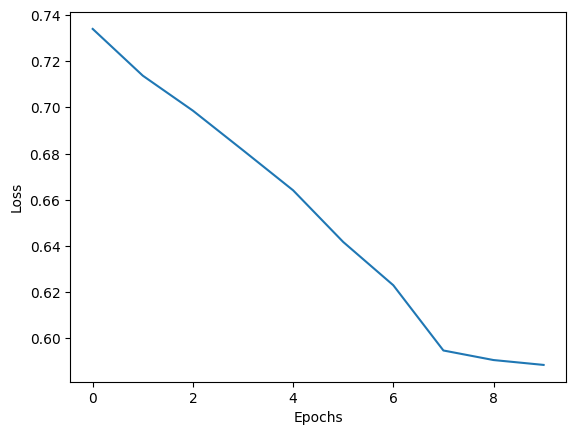

In [118]:
history_df = pd.DataFrame(history)
plt.plot(history_df['train_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [202]:
test_preds = []
test_labels = []

with torch.no_grad():
    train_acc = 0
    for indices, labels in test_dataloader:
        test_labels.append(labels)
        indices, labels = indices.to(device), labels.to(device)
        preds = model(indices)
        test_preds.append(torch.argmax(preds, -1).detach().cpu())
        acc = accuracy(preds, labels)

        train_acc += acc

    train_acc /= len(test_dataloader)

print(f"test_acc: {train_acc}%")

test_acc: 75.36242603550296%


In [161]:
text = "i feel so down an depressed"

def input_to_indices(dataset, text):
    print(f"original text: {text}")
    # clean and tokenize, pad and get indices
    clean_text = dataset.clean_data(text)
    print(f"cleaned_data: {clean_text}")
    tokens = dataset.tokenize_data(clean_text)
    print(f"text tokens: {tokens}")
    padded_tokens = dataset.pad_token(tokens, dataset.longest_seq)
    print(f"padded_tokens: {padded_tokens}")
    indices = dataset.create_indices(dataset.vocab, padded_tokens)
    print(f"indices: {indices}")

    return indices

indices = torch.tensor(input_to_indices(dataset, text)).to(device).unsqueeze(0)

# pass indices through model
with torch.no_grad():
    pred = model(indices)

pred_id = torch.argmax(pred,-1).item()
prediction = list(dataset.label_map.keys())[pred_id]
print(f"\nprediction: {prediction}")

original text: i feel so down an depressed
cleaned_data: i feel so down an depressed
text tokens: ['feel', 'depressed']
padded_tokens: ['feel', 'depressed', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
indices: [9229, 7403, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

prediction: negative


In [150]:
# save the model
torch.save(model.state_dict(), "sentiment_classifier_weights.pth")

### Metrics

In [212]:
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix
import seaborn as sns

In [209]:
precision = MulticlassPrecision(num_classes=3)
recall =MulticlassRecall(num_classes=3)
f1 = MulticlassF1Score(num_classes=3)
confusion_mat = MulticlassConfusionMatrix(num_classes=3)

In [204]:
test_preds = torch.cat(test_preds)
test_labels = torch.cat(test_labels)

In [210]:
precision_score = precision(test_preds, test_labels)
recall_score = recall(test_preds, test_labels)
f1_score = f1(test_preds, test_labels)
conf_mat = confusion_mat(test_preds, test_labels)

print(f"precision: {precision_score}")
print(f"recall: {recall_score}")
print(f"f1_score: {f1_score}")


precision: 0.7663800120353699
recall: 0.7488197088241577
f1_score: 0.7551962733268738


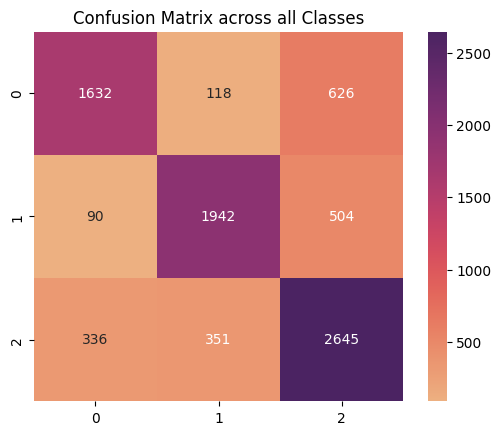

In [222]:
sns.heatmap(conf_mat, cmap='flare', annot=True, fmt='d', square=True)
plt.title("Confusion Matrix across all Classes")
plt.show()